## Appendix

### Implementation of LSTM

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import load_model
# Keras is a high-level neural network library that runs on top of TensorFlow. Both provide high-level APIs used for easily building and training models, but Keras is more user-friendly
import io
from google.colab import files
uploaded = files.upload()

Saving cv.csv to cv.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


The nature of the input sequences as appended text features in a sentence (sequence) makes LSTM an excellent choice for the task.<br>

In [3]:
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
cv = pd.read_csv(io.BytesIO(uploaded['cv.csv']))
train = pd.concat([train, cv], ignore_index=True)
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

train=train.head(126000)
test=test.head(6750)

In [4]:
train_text = (train['book_title'].map(str) + ' ~~~ ' + train['sentence'].map(str)).to_numpy()
train_labels = train['sent_spoil'].to_numpy().astype(np.int32)

test_text = (test['book_title'].map(str) + ' ~~~ ' + test['sentence'].map(str)).to_numpy()
test_labels = test['sent_spoil'].to_numpy().astype(np.int32)

In [5]:
reviewMaxLen = 700

tokenizer = Tokenizer(num_words=8000)  #Vectorize a group of words.
tokenizer.fit_on_texts(train_text) #update the internal vocabulary for the texts list
sequences = tokenizer.texts_to_sequences(train_text)  #Transforms each text in texts to a sequence of integers.
padded = pad_sequences(sequences, maxlen=reviewMaxLen) #Provides padding for sequences less than given length

### How does padding affect LSTM?

Since LSTMs and CNNs take inputs of the same length and dimension, input images and sequences are padded to maximum length while testing and training. This padding can affect the way the networks function and can make a great deal when it comes to performance and accuracies

Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences.

Eg: [1],[2,3],[1,2,3] is saved as:[0,0,1],[0,2,3],[1,2,3]

Dropout is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network. This has the effect of reducing overfitting and improving model performance

In [6]:
#HERE
model = Sequential() #Sequential provides training and inference features on this model.
model.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=reviewMaxLen) )   #Word embeddings provide a dense representation of words and their relative meaning
model.add(SpatialDropout1D(0.25))  #Drops 1D feature maps
model.add(LSTM(32, dropout=0.1, return_sequences=True))
model.add(LSTM(32, dropout=0.2))
model.add(Dropout(0.4)) #Dropout layers are important in training CNNs because they prevent overfitting on the training data. If they aren't present, the first batch of training samples influences the learning in a disproportionately high manner. Dropouts help disabling neurons randomly. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better.
model.add(Dense(1, activation='sigmoid')) #Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense
opt = keras.optimizers.Adam(learning_rate=0.003) #its name is derived from adaptive moment estimation, and the reason it's called that is because Adam uses estimations of first and second moments of gradient to adapt the learning rate for each weight of the neural network
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=[tf.keras.metrics.AUC()])

In [8]:
history = model.fit(padded, train_labels, validation_split=0.0527, epochs=3, batch_size=64, verbose=1)
model.save('model')

Epoch 1/3
1865/1865 [==============================] - 1221s 655ms/step - loss: 0.1405 - auc: 0.6459 - val_loss: 0.1279 - val_auc: 0.8158
Epoch 2/3
1865/1865 [==============================] - 1213s 651ms/step - loss: 0.1106 - auc: 0.8460 - val_loss: 0.1130 - val_auc: 0.8665
Epoch 3/3
1865/1865 [==============================] - 1217s 652ms/step - loss: 0.0934 - auc: 0.9043 - val_loss: 0.1101 - val_auc: 0.8773


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [9]:
model = load_model('model')

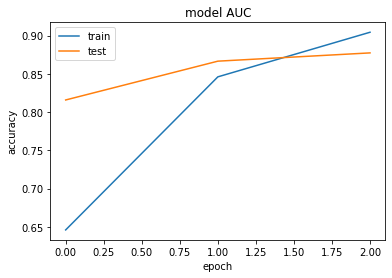

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**ROC:**<br>
Receiver operating characteristic curve a.k.a ROC is a graphic plot illustrates the ability of a binary classifier system as its discrimination threshold is varied<br>
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds<br>

The receiver operating characteristic (ROC) curve is a two dimensional graph in which the false positive rate is plotted on the X axis and the true positive rate is plotted on the Y axis.

**AUC:**<br>
Area Under the Curve, a.k.a. AUC is the percentage of this area that is under this ROC curve, ranging between 0~1

**FPR:** false positive rates<br>
**TPR:** true positive rates

In [11]:
predictions = []
i = 0
for text in test_text:
    if i % 1000 == 0:
        print(i)
    i += 1
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=reviewMaxLen)
    prediction = model.predict(pad).item()
    predictions.append(prediction)
predictions = np.array(predictions)

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions)
auc_keras = auc(fpr_keras, tpr_keras)

print(auc_keras)

0
1000
2000
3000
4000
5000
6000
0.8375807376797764
